In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from xgboost import XGBClassifier

In [2]:
DATA_DIR = Path("tree_data_training")
TREE_DATA = Path("final_data/trees/")
FEATURE_COLS = ['grid_id', 'has_tree', 'avg_height', 'avg_diameter', 'avg_year',
       'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus',
       'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend', 'Incident_ID', 'Date',
       'Hour', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'Label',
       'average_soil_moisture', 'average_soil_temperature', 'num_trees']




TEST_PERCENTAGE = 0.2 # percentage of total
VALIDATION_PERCENTAGE = 0.25 # percentage of (1-TEST_PERCENTAGE)*total
ID_KEY = "Incident_ID"
LABEL_KEY = "Label"

SOIL_MOISTURE_COLUMNS = [
    'soil_moisture_0_to_7cm',
    'soil_moisture_7_to_28cm', 
    'soil_moisture_28_to_100cm', 
    'soil_moisture_100_to_255cm'
]

SOIL_TEMPERATURE_COLUMNS = [
    'soil_temperature_0_to_7cm',
    'soil_temperature_7_to_28cm',
    'soil_temperature_28_to_100cm',
    'soil_temperature_100_to_255cm',
]


## Merging separate sets

In [3]:
# Load in training and testing sets
positive_path = TREE_DATA / "trees_new_grid_pos_samples.csv"
negative_path_t = TREE_DATA / "trees_new_grid_neg_samples_true.csv"
negative_path_f = TREE_DATA / "trees_new_grid_neg_samples_false.csv" 
negative_path_r = TREE_DATA / "trees_new_grid_neg_samples_random.csv" 

positive_samples_df = pd.read_csv(positive_path, sep=",", encoding="utf-8")
negative_samples_df_t = pd.read_csv(negative_path_t, sep=",", encoding="utf-8")
negative_samples_df_f = pd.read_csv(negative_path_f, sep=",", encoding="utf-8")
negative_samples_df_r = pd.read_csv(negative_path_r, sep=",", encoding="utf-8")


In [4]:
negative_samples_df = pd.concat([negative_samples_df_t, negative_samples_df_f, negative_samples_df_r], axis=0)

In [5]:
negative_samples_df.has_tree.value_counts()

has_tree
False    2387
True     2107
Name: count, dtype: int64

In [6]:
# Make sure both df's have identifiable id
# Not really necessary but makes things easier
positive_samples_df[ID_KEY] = ["P"+str(id_) for id_ in positive_samples_df['Incident_ID']]
negative_samples_df[ID_KEY] = ["N"+str(id_) for id_ in range(len(negative_samples_df))]

In [7]:
# Assign labels
positive_samples_df[LABEL_KEY] = 1
negative_samples_df[LABEL_KEY] = 0

In [8]:
positive_samples_df = positive_samples_df.fillna(0)
negative_samples_df = negative_samples_df.fillna(0)

In [9]:
# Merge df's
pos_columns = positive_samples_df.columns
neg_columns = negative_samples_df.columns
common_cols = pos_columns.intersection(neg_columns)

positive_sub_df = positive_samples_df[common_cols]
negative_sub_df = negative_samples_df[common_cols]

tree_training_df = pd.concat([positive_sub_df, negative_sub_df], axis=0)

In [10]:
def average_across_cols(
    df,
    cols,
    new_col
):
    df[new_col] = df[cols].mean(axis=1)
    return df

In [11]:
tree_training_df = average_across_cols(tree_training_df, SOIL_MOISTURE_COLUMNS, "average_soil_moisture")
tree_training_df = average_across_cols(tree_training_df, SOIL_TEMPERATURE_COLUMNS, "average_soil_temperature")

In [12]:
[tree_training_df.drop(col, axis=1, inplace=True) for col in SOIL_MOISTURE_COLUMNS]
[tree_training_df.drop(col, axis=1, inplace=True) for col in SOIL_TEMPERATURE_COLUMNS]

[None, None, None, None]

In [13]:
# create num trees col
tree_names = ['Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus',
       'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
tree_training_df['num_trees'] = tree_training_df[tree_names].sum(axis=1)

In [14]:
tree_training_df.columns

Index(['grid_id', 'has_tree', 'avg_height', 'avg_diameter', 'avg_year',
       'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus',
       'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend', 'Incident_ID', 'Date',
       'Hour', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'Label',
       'average_soil_moisture', 'average_soil_temperature', 'num_trees'],
      dtype='object')

## Train - Validate - Test split

In [15]:
df = tree_training_df

In [16]:
# split train - test
train_ids, test_ids, train_labels, test_labels = train_test_split(df[ID_KEY], df[LABEL_KEY], test_size=TEST_PERCENTAGE, stratify=df[LABEL_KEY], random_state=42)
# train_ids, validation_ids = train_test_split(train_ids, test_size=VALIDATION_PERCENTAGE, stratify=train_labels, random_state=35)

In [17]:
train_set = df[df[ID_KEY].isin(train_ids)]
test_set = df[df[ID_KEY].isin(test_ids)]
# validation_set = df[df[ID_KEY].isin(validation_ids)]

In [129]:
feature_cols = [col for col in FEATURE_COLS if col not in SOIL_MOISTURE_COLUMNS and col not in SOIL_TEMPERATURE_COLUMNS]

feature_cols.append('num_trees')

print(feature_cols)

x_train = train_set[feature_cols]
y_train = train_set[LABEL_KEY]
x_test = test_set[feature_cols]
y_test = test_set[LABEL_KEY]

['avg_height', 'avg_year', 'has_tree', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'num_trees']


In [33]:
def make_train_test(
    df,
    seed = 42,
    feature_cols = FEATURE_COLS
):
    train_ids, test_ids, train_labels, test_labels = train_test_split(df[ID_KEY], df[LABEL_KEY], test_size=TEST_PERCENTAGE, stratify=df[LABEL_KEY], random_state=seed)
    
    feature_cols = [col for col in feature_cols if col not in SOIL_MOISTURE_COLUMNS and col not in SOIL_TEMPERATURE_COLUMNS]
    print(f"Using feature cols {feature_cols}")
    
    train_set = df[df[ID_KEY].isin(train_ids)]
    test_set = df[df[ID_KEY].isin(test_ids)]

    x_train = train_set[feature_cols]
    y_train = train_set[LABEL_KEY]
    x_test = test_set[feature_cols]
    y_test = test_set[LABEL_KEY]

    return x_train, y_train, x_test, y_test


## Random forest

In [70]:
# clf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10, random_state=42, n_jobs=-1)

clf = RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_split=2, min_samples_leaf=8, random_state=42, n_jobs=-1)

In [85]:
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.82      0.76      0.79       661
           1       0.64      0.72      0.68       393

    accuracy                           0.74      1054
   macro avg       0.73      0.74      0.73      1054
weighted avg       0.75      0.74      0.75      1054



In [89]:
test = tree_training_df[tree_training_df.has_tree == False][:200]

In [93]:
x_train, y_train, x_test, y_test = make_train_test(test)
test_pred = clf.predict(x_test)

In [94]:
test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
import pickle
#save model
with open("models/trees/rf_test_n20_md5_ms2_msl8.pkl", "wb") as f:
    pickle.dump(clf, f)

In [21]:
rf_f1 = f1_score(y_true=y_test, y_pred=predictions)
print(rf_f1)

0.21076233183856502


### Optimization

#### grid opt

In [22]:
clf  = RandomForestClassifier(random_state=42, n_jobs=-1)

In [23]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': np.arange(20, 240, 30),
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 22, 2],
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': np.arange(0.2, 1.0, 0.2)
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)

In [24]:
# Fit the model to the data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Parameters: {best_params}')
print(f'Best Model Accuracy: {accuracy:.2f}')

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits
[CV 1/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.693 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.668 total time=   0.1s
[CV 3/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.703 total time=   0.1s
[CV 1/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.689 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.667 total time=   0.1s
[CV 3/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.702 total time=   0.1s
[CV 1/3] END max_depth=5, max_features=0.2, min_samples_leaf=1, min_samples_split=2, n_estimators=80;, score=0.687 total time=   0

KeyboardInterrupt: 

## XGBoost

In [63]:
tree_training_df.average_soil_temperature.value_counts()

average_soil_temperature
14.0480    23
14.2625    16
14.1115    16
14.1245    16
14.2875    13
           ..
8.1890      1
17.8370     1
15.6445     1
18.4565     1
4.7315      1
Name: count, Length: 5040, dtype: int64

In [141]:
# clf = XGBClassifier(verbosity=2, max_depth=15, subsample=0.9)
import xgboost

cols = ['has_tree', 'avg_height', 'avg_year', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'weather_code', 'pressure_msl', 'surface_pressure',
       'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m',
       'average_soil_moisture', 'average_soil_temperature', 'num_trees']

best_cols = ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m',
       'average_soil_moisture', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

tree_names = ['Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

# test_cols += tree_names

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=best_cols,  seed=42)

d_train = xgboost.DMatrix(x_train, label=y_train)
d_test = xgboost.DMatrix(x_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

Using feature cols ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'average_soil_moisture', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
[0]	test-logloss:0.61083
[100]	test-logloss:0.44324
[200]	test-logloss:0.40087
[300]	test-logloss:0.38382
[400]	test-logloss:0.37667
[500]	test-logloss:0.37128
[600]	test-logloss:0.36667
[700]	test-logloss:0.36304
[800]	test-logloss:0.36017
[900]	test-logloss:0.35632
[1000]	test-logloss:0.35355
[1100]	test-logloss:0.35117
[1200]	test-logloss:0.35003
[1300]	test-logloss:0.34852
[1356]	test-logloss:0.34814


In [142]:
preds = model.predict(xgboost.DMatrix(x_test), )
preds_t = [1 if pred >= 0.5 else 0 for pred in preds]


In [143]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds_t))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       899
           1       0.74      0.76      0.75       393

    accuracy                           0.85      1292
   macro avg       0.82      0.82      0.82      1292
weighted avg       0.85      0.85      0.85      1292



In [43]:
# import pickle
# #save model
# with open("models/trees/xgboost_new_md15_sub90_mixed.pkl", "wb") as f:
#     pickle.dump(clf, f)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

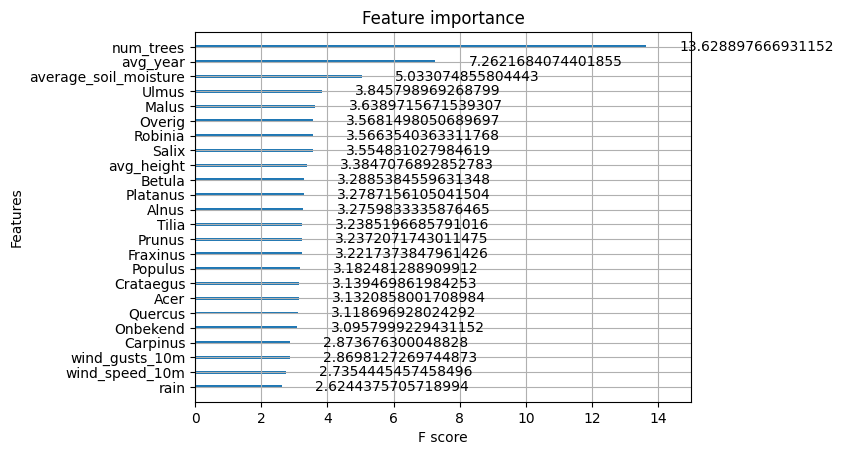

In [139]:
import xgboost
import shap 
xgboost.plot_importance(model, importance_type='gain')

In [144]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])


[15:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

In [146]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'subsample': [0.1, 0.3, 0.5, 0.7, 0.9]
}

clf = XGBClassifier()

best_cols = ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m',
       'average_soil_moisture', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus',
       'Ulmus', 'Carpinus', 'Overig', 'Onbekend']

x_train, y_train, x_test, y_test = make_train_test(tree_training_df, feature_cols=best_cols,  seed = 42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)

# Fit the model to the data
grid_search.fit(x_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Parameters: {best_params}')
print(f'Best Model Accuracy: {accuracy:.2f}')

Using feature cols ['avg_height', 'avg_year', 'apparent_temperature', 'rain', 'wind_speed_10m', 'wind_gusts_10m', 'average_soil_moisture', 'num_trees', 'Fraxinus', 'Salix', 'Alnus', 'Quercus', 'Tilia', 'Acer', 'Populus', 'Betula', 'Prunus', 'Platanus', 'Malus', 'Robinia', 'Crataegus', 'Ulmus', 'Carpinus', 'Overig', 'Onbekend']
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END ........max_depth=5, subsample=0.1;, score=0.545 total time=   0.5s
[CV 2/3] END ........max_depth=5, subsample=0.1;, score=0.720 total time=   0.5s
[CV 3/3] END ........max_depth=5, subsample=0.1;, score=0.774 total time=   0.4s
[CV 1/3] END ........max_depth=5, subsample=0.3;, score=0.573 total time=   0.4s
[CV 2/3] END ........max_depth=5, subsample=0.3;, score=0.729 total time=   0.4s
[CV 3/3] END ........max_depth=5, subsample=0.3;, score=0.737 total time=   0.4s
[CV 1/3] END ........max_depth=5, subsample=0.5;, score=0.584 total time=   0.4s
[CV 2/3] END ........max_depth=5, subsample

In [25]:
clf = XGBClassifier(verbosity=2, max_depth=5, subsample=0.7)

x_train, y_train, x_test, y_test = make_train_test(tree_training_df)

clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       899
           1       0.69      0.70      0.70       393

    accuracy                           0.82      1292
   macro avg       0.78      0.78      0.78      1292
weighted avg       0.82      0.82      0.82      1292



In [27]:
feature_importances = clf.feature_importances_
features = x_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
3              num_trees    0.076090
27              snowfall    0.065114
1               avg_year    0.046133
5                  Salix    0.042402
6                  Alnus    0.032643
15               Robinia    0.032142
17                 Ulmus    0.030700
14                 Malus    0.030484
8                  Tilia    0.029839
0             avg_height    0.029063
19                Overig    0.028876
11                Betula    0.028715
4               Fraxinus    0.027132
16             Crataegus    0.027079
7                Quercus    0.027026
18              Carpinus    0.026746
12                Prunus    0.026711
13              Platanus    0.026094
9                   Acer    0.025221
34        wind_gusts_10m    0.025184
10               Populus    0.025113
26                  rain    0.025101
20              Onbekend    0.024869
32        wind_speed_10m    0.023620
23          dew_point_2m    0.023136
21        temperature_2m    0.022859
2

In [166]:
import pickle
#save model
with open("models/trees/xgboost_new_md20_sub50_tfr.pkl", "wb") as f:
    pickle.dump(clf, f)

### LR

In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

x_train, y_train, x_test, y_test = make_train_test(df, seed = 42)

clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print(f1_score(y_pred=predictions, y_true=y_test))

0.5983827493261457


/Users/Reimer/opt/anaconda3/envs/fundamentals-data-science/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
from TreeInference import makeTreePrediction
from pathlib import Path

predictor = makeTreePrediction(model_name="xgboost_new_md15_sub90_mixed.pkl", grid_path=Path("data_bomen/grid_enriched_200_new.csv"), hours_to_predict=8)
pred_dict = predictor.get_predictions()


In [48]:
c = 0
for key, value in pred_dict.items():
    if 0 in value:
        c +=1
        print(f"For {key}: {value}")

print(c)

For 0: [0, 0, 0, 0, 0, 0, 0, 0]
For 1: [0, 0, 0, 0, 0, 0, 0, 0]
For 2: [0, 0, 0, 0, 0, 0, 0, 0]
For 3: [0, 0, 0, 0, 0, 0, 0, 0]
For 4: [0, 0, 0, 0, 0, 0, 0, 0]
For 5: [0, 0, 0, 0, 0, 0, 0, 0]
For 6: [0, 0, 0, 0, 0, 0, 0, 0]
For 7: [0, 0, 0, 0, 0, 0, 0, 0]
For 8: [0, 0, 0, 0, 0, 0, 0, 0]
For 9: [0, 0, 0, 0, 0, 0, 0, 0]
For 10: [0, 0, 0, 0, 0, 0, 0, 0]
For 11: [0, 0, 0, 0, 0, 0, 0, 0]
For 12: [0, 0, 0, 0, 0, 0, 0, 0]
For 13: [0, 0, 0, 0, 0, 0, 0, 0]
For 14: [0, 0, 0, 0, 0, 0, 0, 0]
For 15: [0, 0, 0, 0, 0, 0, 0, 0]
For 16: [0, 0, 0, 0, 0, 0, 0, 0]
For 17: [0, 0, 0, 0, 0, 0, 0, 0]
For 18: [0, 0, 0, 0, 0, 0, 0, 0]
For 19: [0, 0, 0, 0, 0, 0, 0, 0]
For 20: [0, 0, 0, 0, 0, 0, 0, 0]
For 21: [0, 0, 0, 0, 0, 0, 0, 0]
For 22: [0, 0, 0, 0, 0, 0, 0, 0]
For 23: [0, 0, 0, 0, 0, 0, 0, 0]
For 24: [0, 0, 0, 0, 0, 0, 0, 0]
For 25: [0, 0, 0, 0, 0, 0, 0, 0]
For 26: [0, 0, 0, 0, 0, 0, 0, 0]
For 27: [0, 0, 0, 0, 0, 0, 0, 0]
For 28: [0, 0, 0, 0, 0, 0, 0, 0]
For 29: [0, 0, 0, 0, 0, 0, 0, 0]
For 30: [0, 0, 0, 0,